In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sam.stress_addition_model import OLD_STANDARD, sam_prediction
from sam.stress_addition_model import (
    sam_prediction,
    get_sam_lcs,
    OLD_STANDARD
)
from sam import chdir_to_repopath
chdir_to_repopath()
from sam.plotting import plot_sam_prediction
from sam.data_formats import load_datapoints
import os
import matplotlib.pyplot as plt
import pandas as pd
import argparse
from tqdm import tqdm
from copy import deepcopy
from sam.data_formats import read_data
from sam.helpers import pad_c0

In [3]:
names = [
    ("liess_copper_2001", "Food_1% + UV"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_100"),
    ("naeem_Esfenvalerate_2019", "Food_1% + Prochloraz_32"),
    ("naeem_Esfenvalerate_2024", "Food_1% + Temp_25"),
    ("naeem_Mix13_2024", "Temp_25 + Food_1%")
]

In [4]:
def pred_exp(path, exp, new = False, hormesis_index = None, title = None):
    
    settings = deepcopy(OLD_STANDARD)
    settings.cancel_system_stress = new
    
    
    data = read_data(f"data/{path}.xlsx")
    
    data.meta.hormesis_index = hormesis_index
    val = data.additional_stress[exp]
    
    main_fit, stress_fit, sam_sur, sam_stress, additional_stress = sam_prediction(
        data.main_series,
        val,
        data.meta,
        settings=settings,
    )

    lcs = get_sam_lcs(stress_fit=stress_fit, sam_sur=sam_sur, meta=data.meta)

    fig = plot_sam_prediction(
        main_fit,
        stress_fit,
        sam_sur,
        sam_stress,
        survival_max=data.meta.max_survival,
        lcs=lcs,
        title=title,
    )
    if new:
        fig.axes[-1].plot(main_fit.concentration_curve, main_fit.pred_system_stress, label = "system")
        fig.axes[-1].legend()
    plt.show()

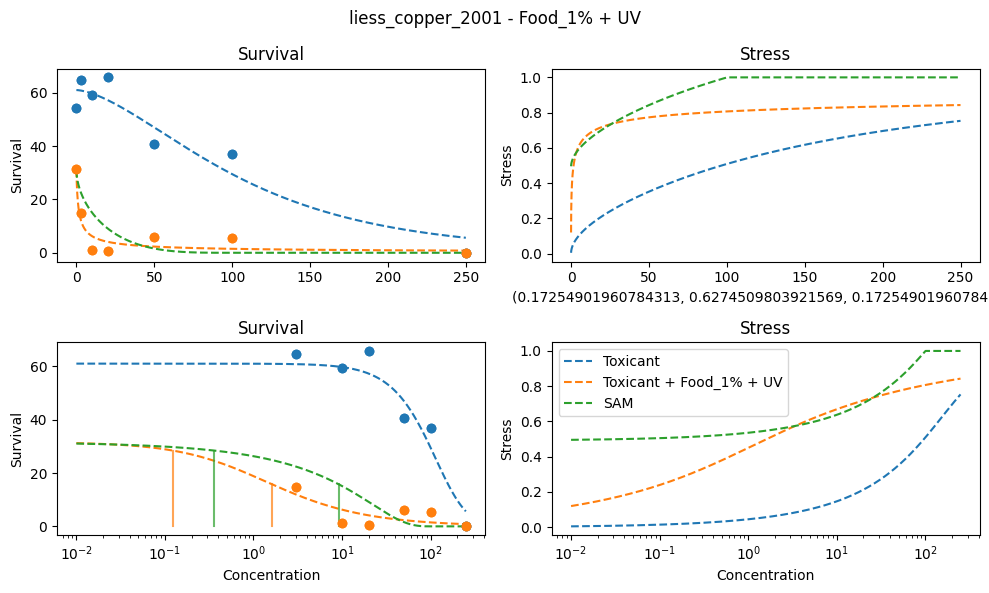

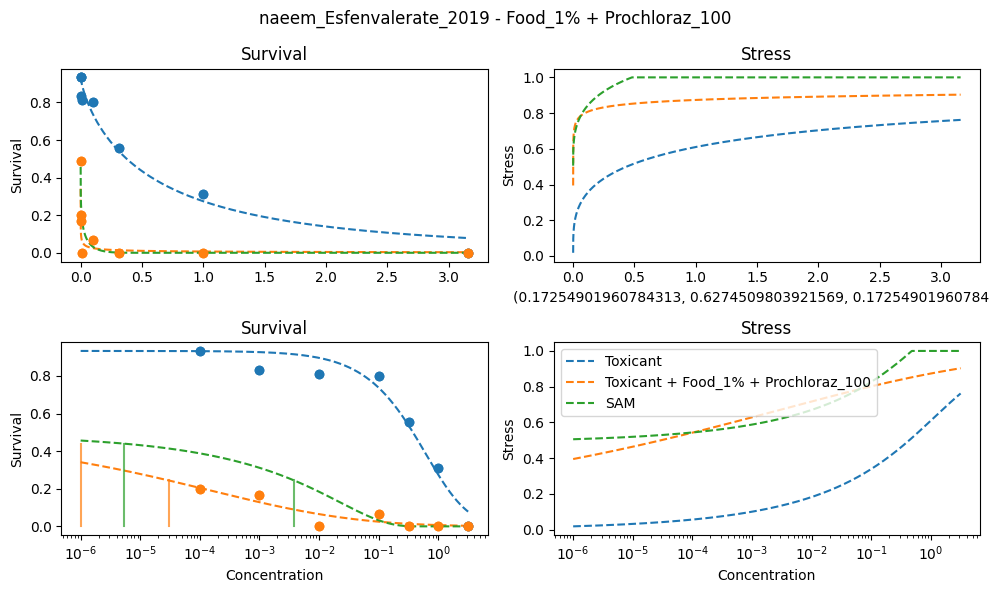

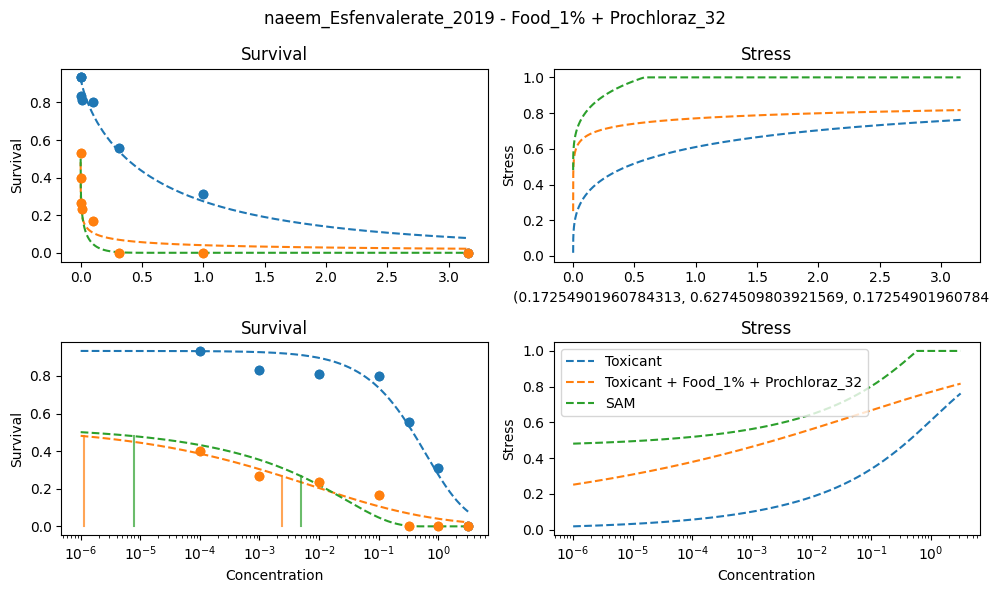

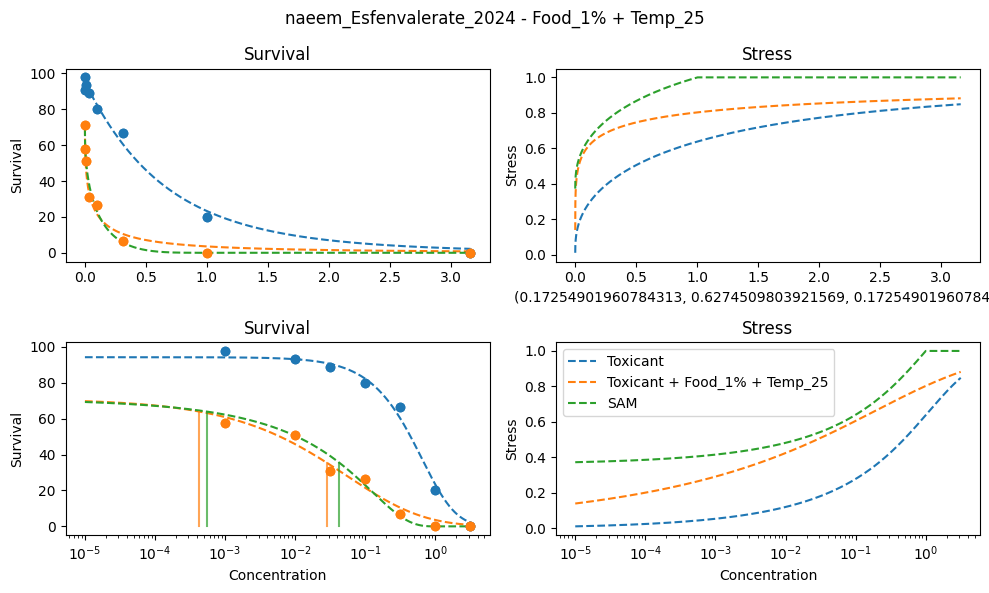

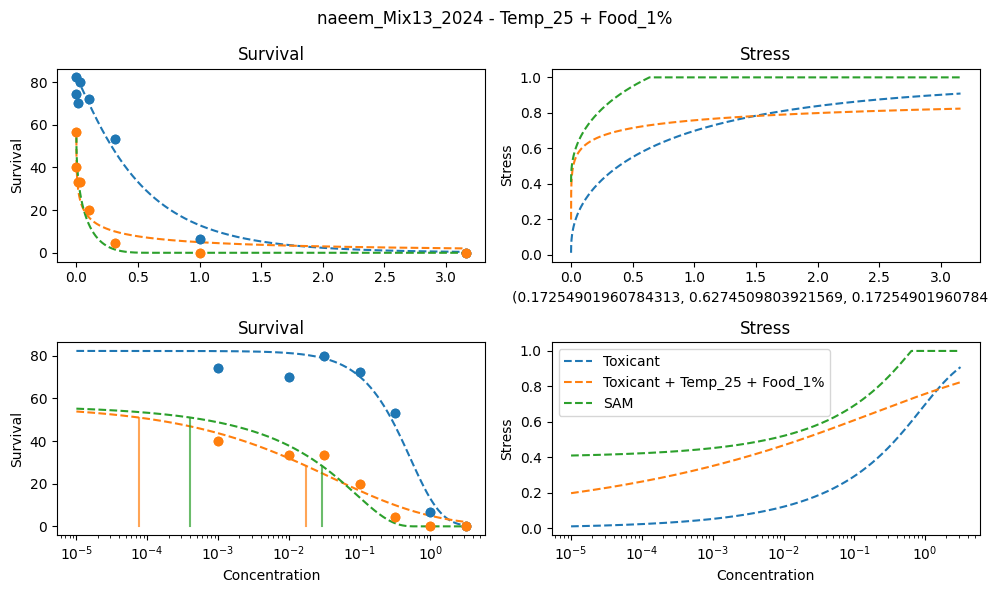

In [5]:
for name in names:
    
    title = " - ".join(name)
    pred_exp(*name, new = False, hormesis_index= None, title=title)
    
    

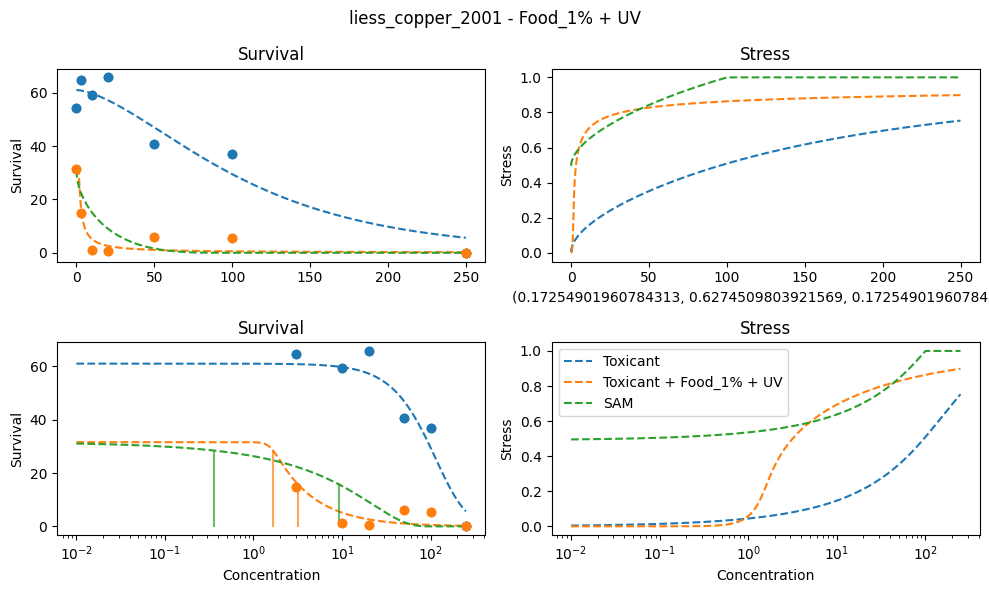

/home/felix/Desktop/sam/src/sam/stress_addition_model.py:107: UserWarning: could not find hormesis index, detecting it
  warn("could not find hormesis index, detecting it")


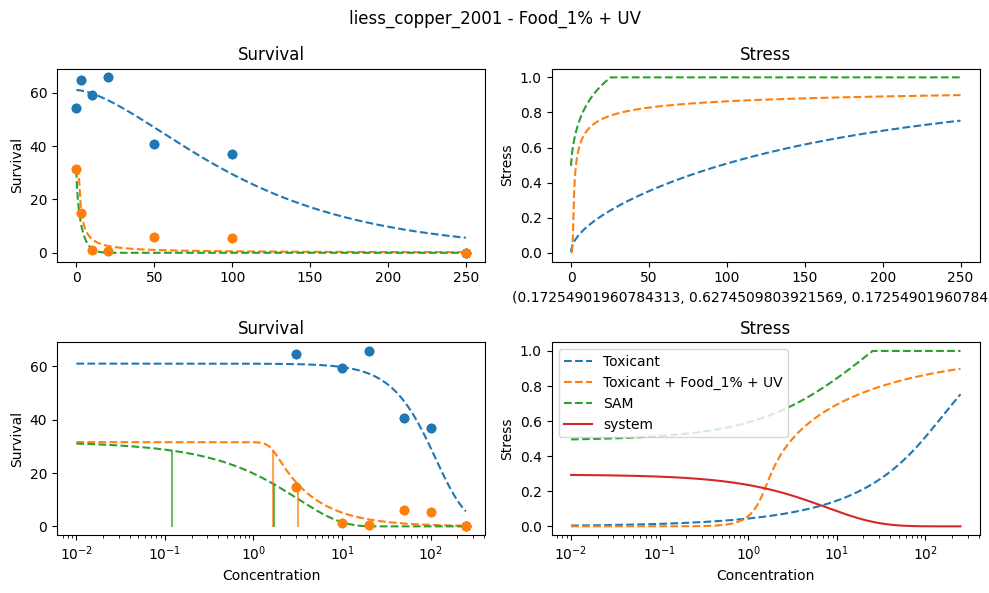

In [34]:
name = names[0]
pred_exp(*name, new = False, hormesis_index= None, title = " - ".join(name))
pred_exp(*name, new = True, hormesis_index= None, title = " - ".join(name))

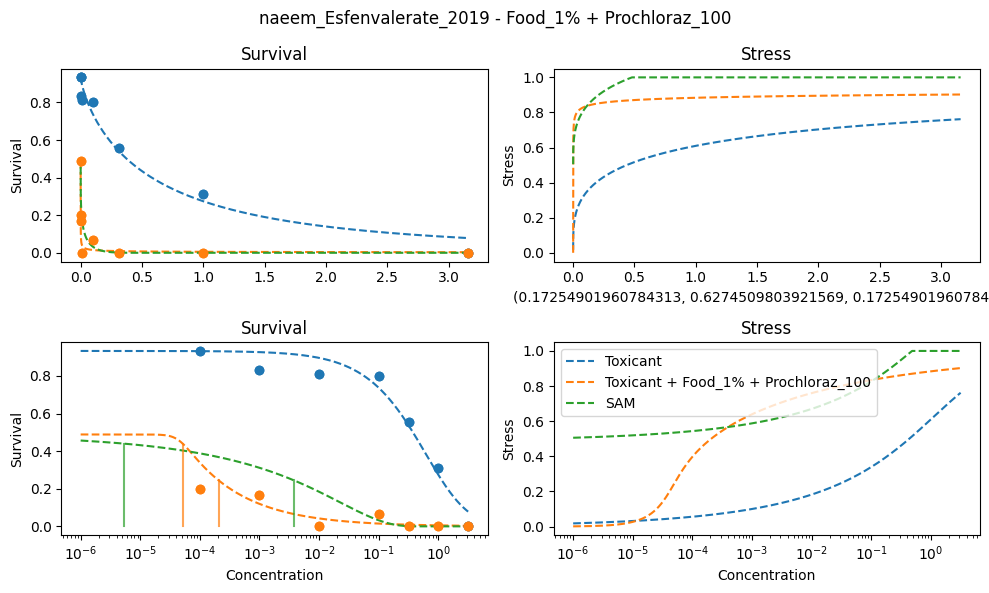

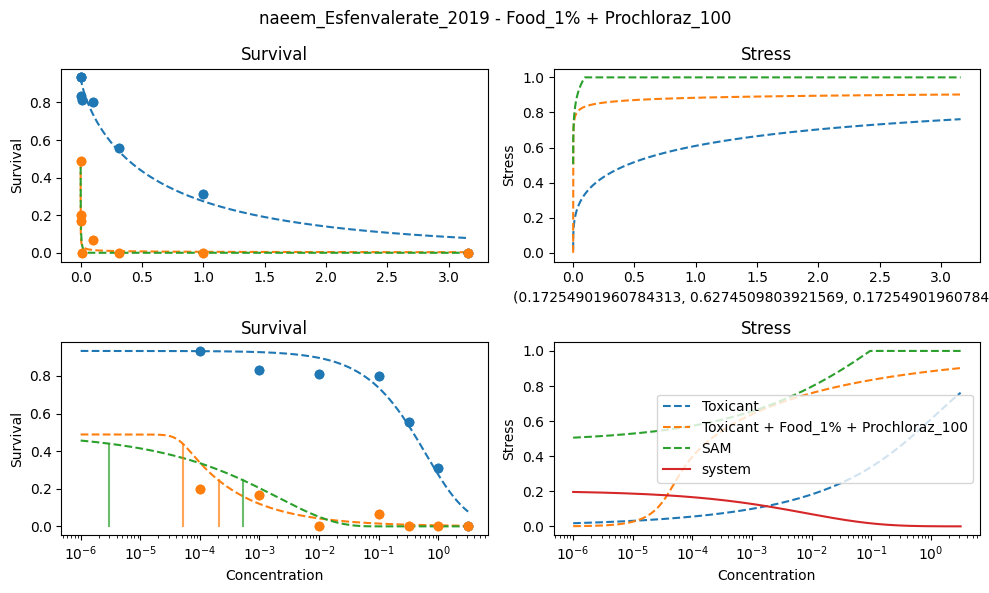

In [36]:
name = names[1]
pred_exp(*name, new = False, hormesis_index= None, title = " - ".join(name))
pred_exp(*name, new = True, hormesis_index= 4, title = " - ".join(name))

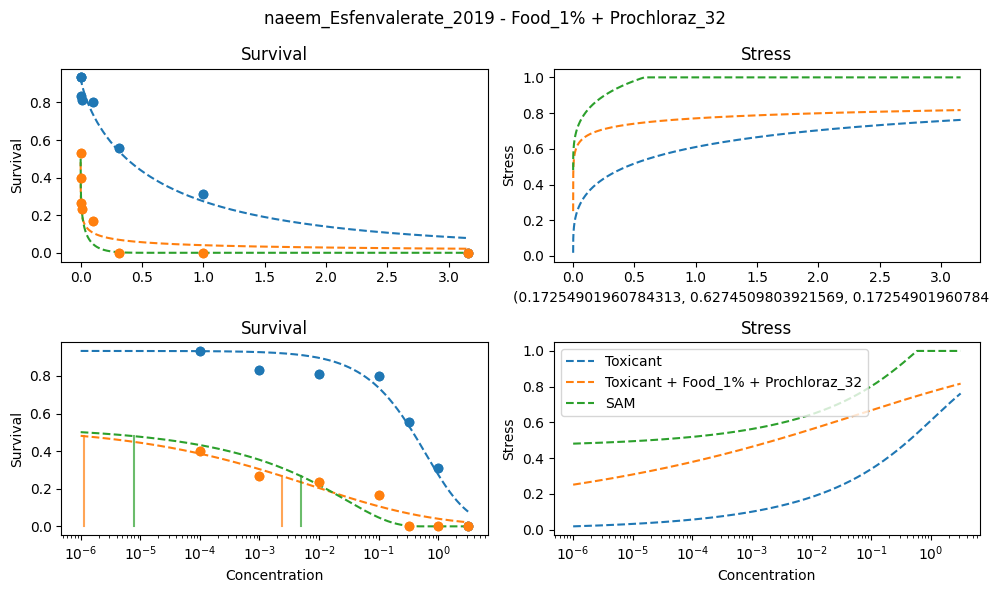

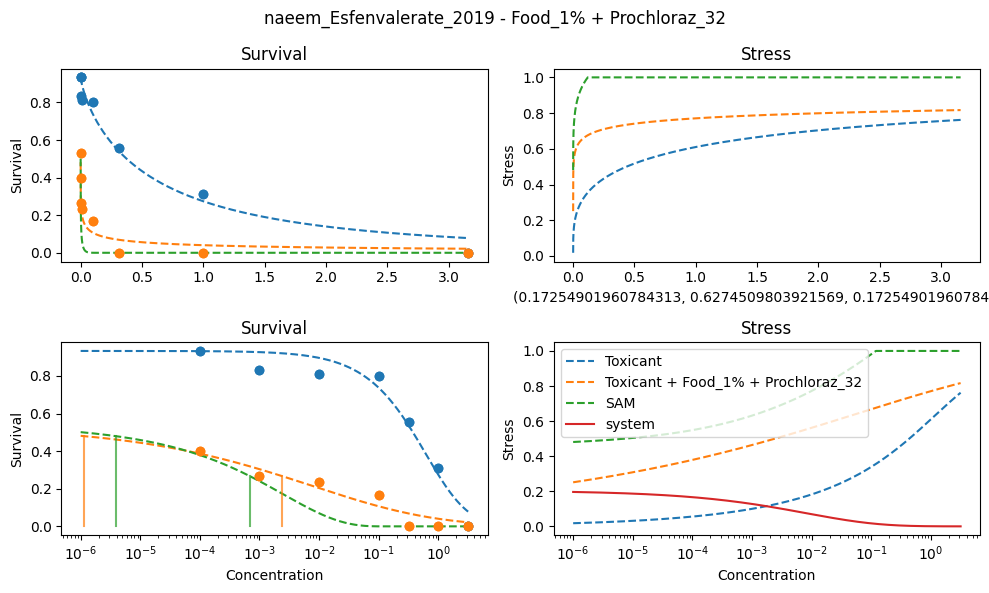

In [7]:
name = names[2]
pred_exp(*name, new = False, hormesis_index= None, title = " - ".join(name))
pred_exp(*name, new = True, hormesis_index= 4, title = " - ".join(name))

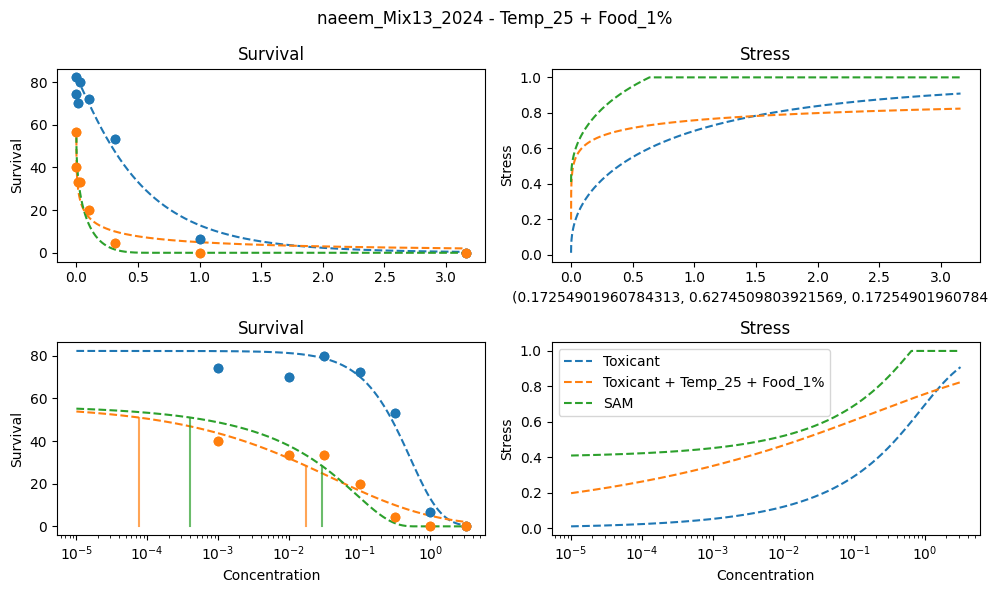

/home/felix/Desktop/sam/src/sam/stress_addition_model.py:107: UserWarning: could not find hormesis index, detecting it to be 4
  hormesis_index = detect_hormesis_index(main_series.survival_rate)


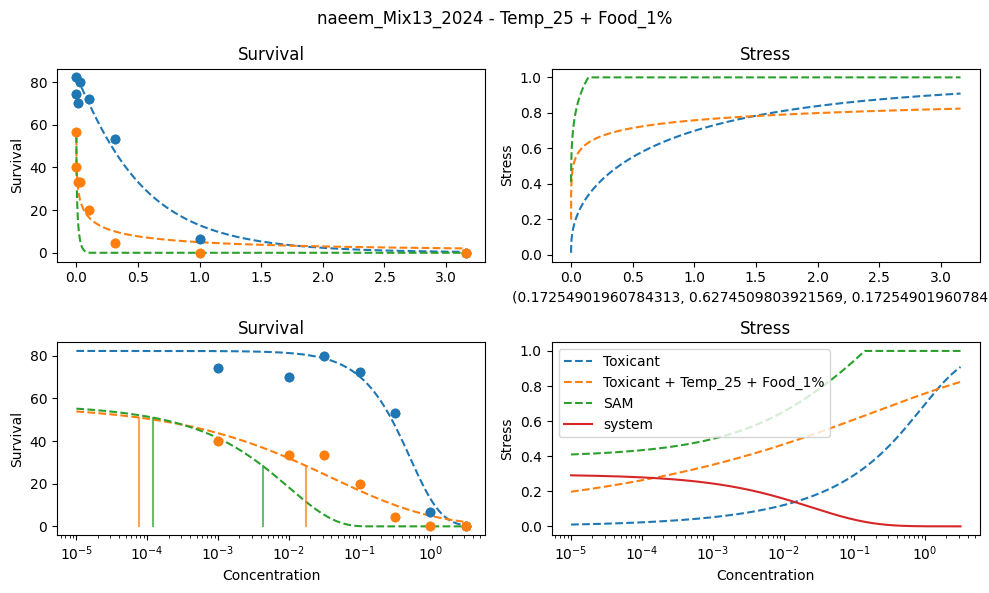

In [14]:
name = names[-1]
pred_exp(*name, new = False, hormesis_index= None, title = " - ".join(name))
pred_exp(*name, new = True, hormesis_index= None, title = " - ".join(name))